## Midline analysis notebook
This notebook generates and analyze skeletons of fish extracted from data generated with [idtracker.ai](idtracker.ai) data.

This notebook requires to have scikit-image, mahotas and the fishmidline package (https://gitlab.com/polavieja_lab/midline) installed. 

If you use this code and/or data generated from [idtracker.ai](idtracker.ai), please cite:

**Romero-Ferrero, F., Bergomi, M.G., Hinz, R.C., Heras, F.J.H., de Polavieja, G.G., (2018). idtracker.ai: Tracking all individuals in large collectives of unmarked animals (under review) (F.R.-F. and M.G.B. contributed equally to this work. Correspondence should be addressed to G.G.d.P: gonzalo.polavieja@neuro.fchampalimaud.org)**

### Import Polavieja Lab's FishMidline from GitLab

Check [the repository](https://gitlab.com/polavieja_lab/midline) to see how it works

In [1]:
!git clone https://gitlab.com/polavieja_lab/midline

fatal: destination path 'midline' already exists and is not an empty directory.


In [2]:
from tqdm import tqdm
import numpy as np
from midline.fishmidline import get_spline
from idtrackerai import Session, ListOfBlobs
import matplotlib.pyplot as plt
from scipy.interpolate import splev

### Load idtracker.ai objects

In [3]:
session = Session.load("../session_test")
list_of_blobs = ListOfBlobs.load(session.blobs_path)

### Compute angles using the get_mideline_angles function from the package *fishmidline*

In [4]:
n_points = 10

all_angles = np.full(
    (
        session.number_of_frames,
        session.number_of_animals,
        n_points,
    ),
    np.nan,
)

for frame_number in tqdm(range(session.number_of_frames), desc="computing..."):
    blobs_in_frame = list_of_blobs.blobs_in_video[frame_number]
    for blob in blobs_in_frame:
        if blob.is_an_individual and blob.identity is not None:
            blob_spline = get_spline(blob)

            spline_samples = np.linspace(0, 1, n_points)
            angles = np.arctan2(*splev(spline_samples, blob_spline, der=1))

            all_angles[frame_number, blob.identity - 1] = angles

computing...: 100%|██████████| 508/508 [00:05<00:00, 93.25it/s] 


In [5]:
np.save(session.session_folder / "midline_angles.npy", all_angles)

### Plot fish mideline extraction steps

In [6]:
midlines_angles: np.ndarray = np.load(session.session_folder / "midline_angles.npy")

[(-3.141592653589793, 3.141592653589793)]

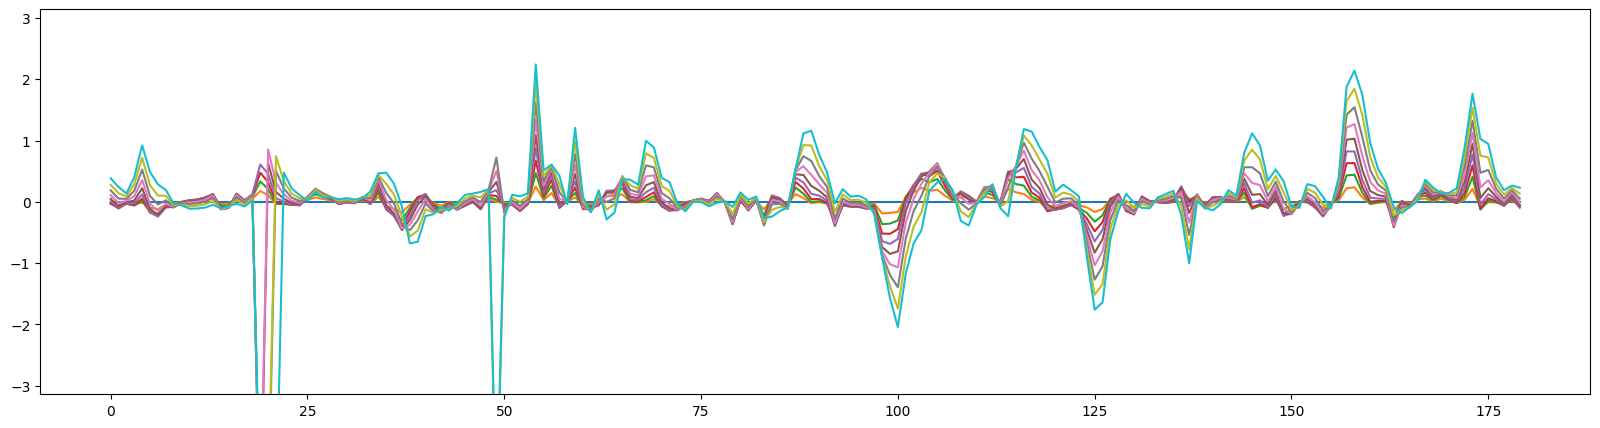

In [7]:
identity = 8
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.plot(
    midlines_angles[20:200, identity - 1]
    - midlines_angles[20:200, identity - 1, 0][..., None]
)
ax.set(ylim=(-np.pi, np.pi))

### Plot distributions of angles for different segment-angles along the midline

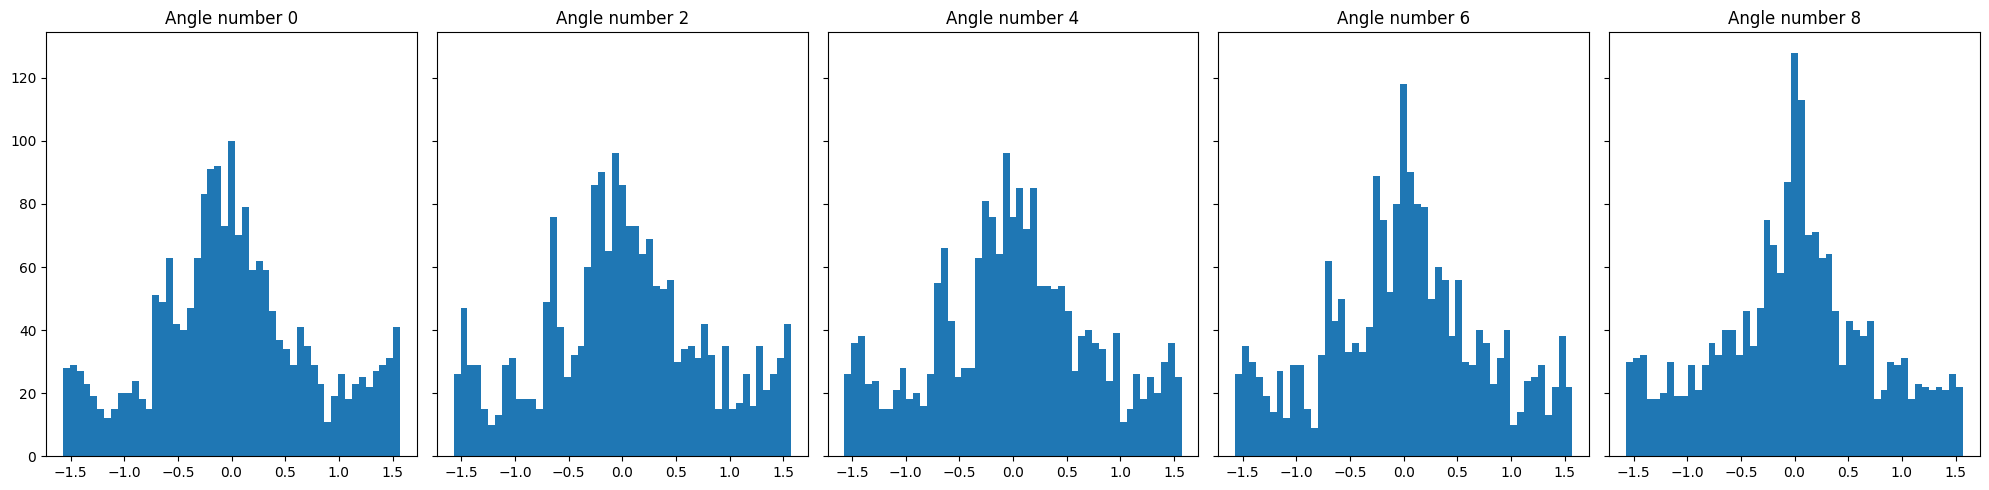

In [15]:
fig, ax_arr = plt.subplots(1, 5, figsize=(20, 5), sharex=True, sharey=True)
bins = np.linspace(-np.pi / 2, np.pi / 2, 50)
for i, angle_index in enumerate(range(0, midlines_angles.shape[2], 2)):
    ax_arr[i].hist(midlines_angles[..., angle_index].flatten(), bins=bins)
    ax_arr[i].set(title=f"Angle number {angle_index}")
fig.tight_layout()